In [1]:
import CASBI
import CASBI.utils as utils
from CASBI.generator import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde



In [2]:
data = pd.read_parquet('../../MW_MH/data/preprocessing_subsample/preprocess_training_set_Galaxy_name_subsample.parquet')
mean_and_std_df = pd.read_parquet('../../MW_MH/data/preprocessing_subsample/mean_and_std_preprocessing.parquet')
data = utils.rescale(data, mean_and_std_path='../../MW_MH/data/preprocessing_subsample/mean_and_std_preprocessing.parquet', inverse=True)
print('Number of Galaxy: ',len(data['Galaxy_name'].unique()))

Number of Galaxy:  4343


Text(0, 0.5, '[O/Fe]')

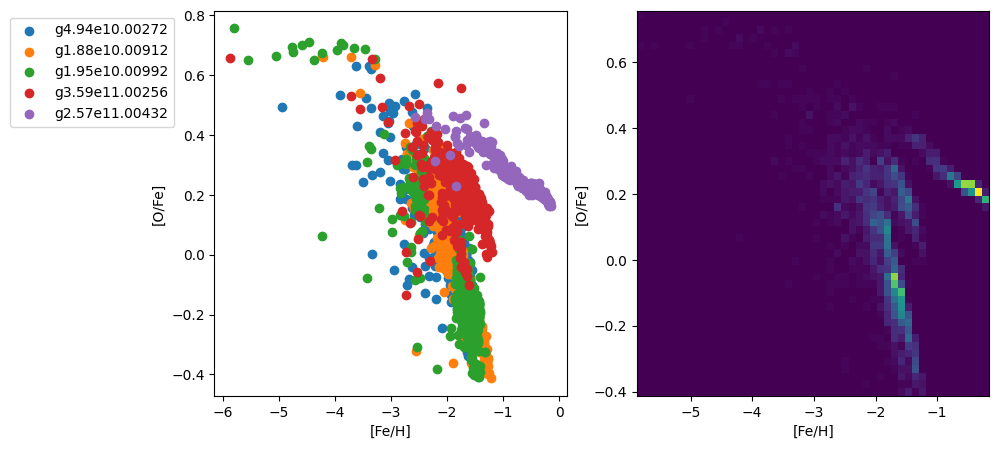

In [4]:
fake_halo_name = data['Galaxy_name'].sample(5)
fake_halo = data[data['Galaxy_name'].isin(fake_halo_name)]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
for name in fake_halo_name:
    ax.scatter(fake_halo[fake_halo['Galaxy_name']==name]['feh'], fake_halo[fake_halo['Galaxy_name']==name]['ofe'], label=name)
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')
ax.legend(bbox_to_anchor=(-0.60, 1), loc='upper left')
    
ax = fig.add_subplot(122)
feh_ofe = fake_halo[['feh', 'ofe']].values
num_bins=100
hist, xedges, yedges = np.histogram2d(feh_ofe[:,0], feh_ofe[:,1], bins=num_bins)
ax.hist2d(x=fake_halo['feh'], y=fake_halo['ofe'], bins=50, cmap='viridis');
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')


In [6]:
conditions = data[data.columns.difference(['Galaxy_name', 'feh', 'ofe'], sort=False)].drop_duplicates()
conditions_rescale = pd.DataFrame(columns=conditions.columns)
for col in conditions_rescale.columns:   
                mean = mean_and_std_df.loc[0, f'mean_{col}'] 
                std  = mean_and_std_df.loc[0, f'std_{col}'] 
                conditions_rescale[col] = conditions[col]*std + mean
print(len(conditions_rescale))

4343


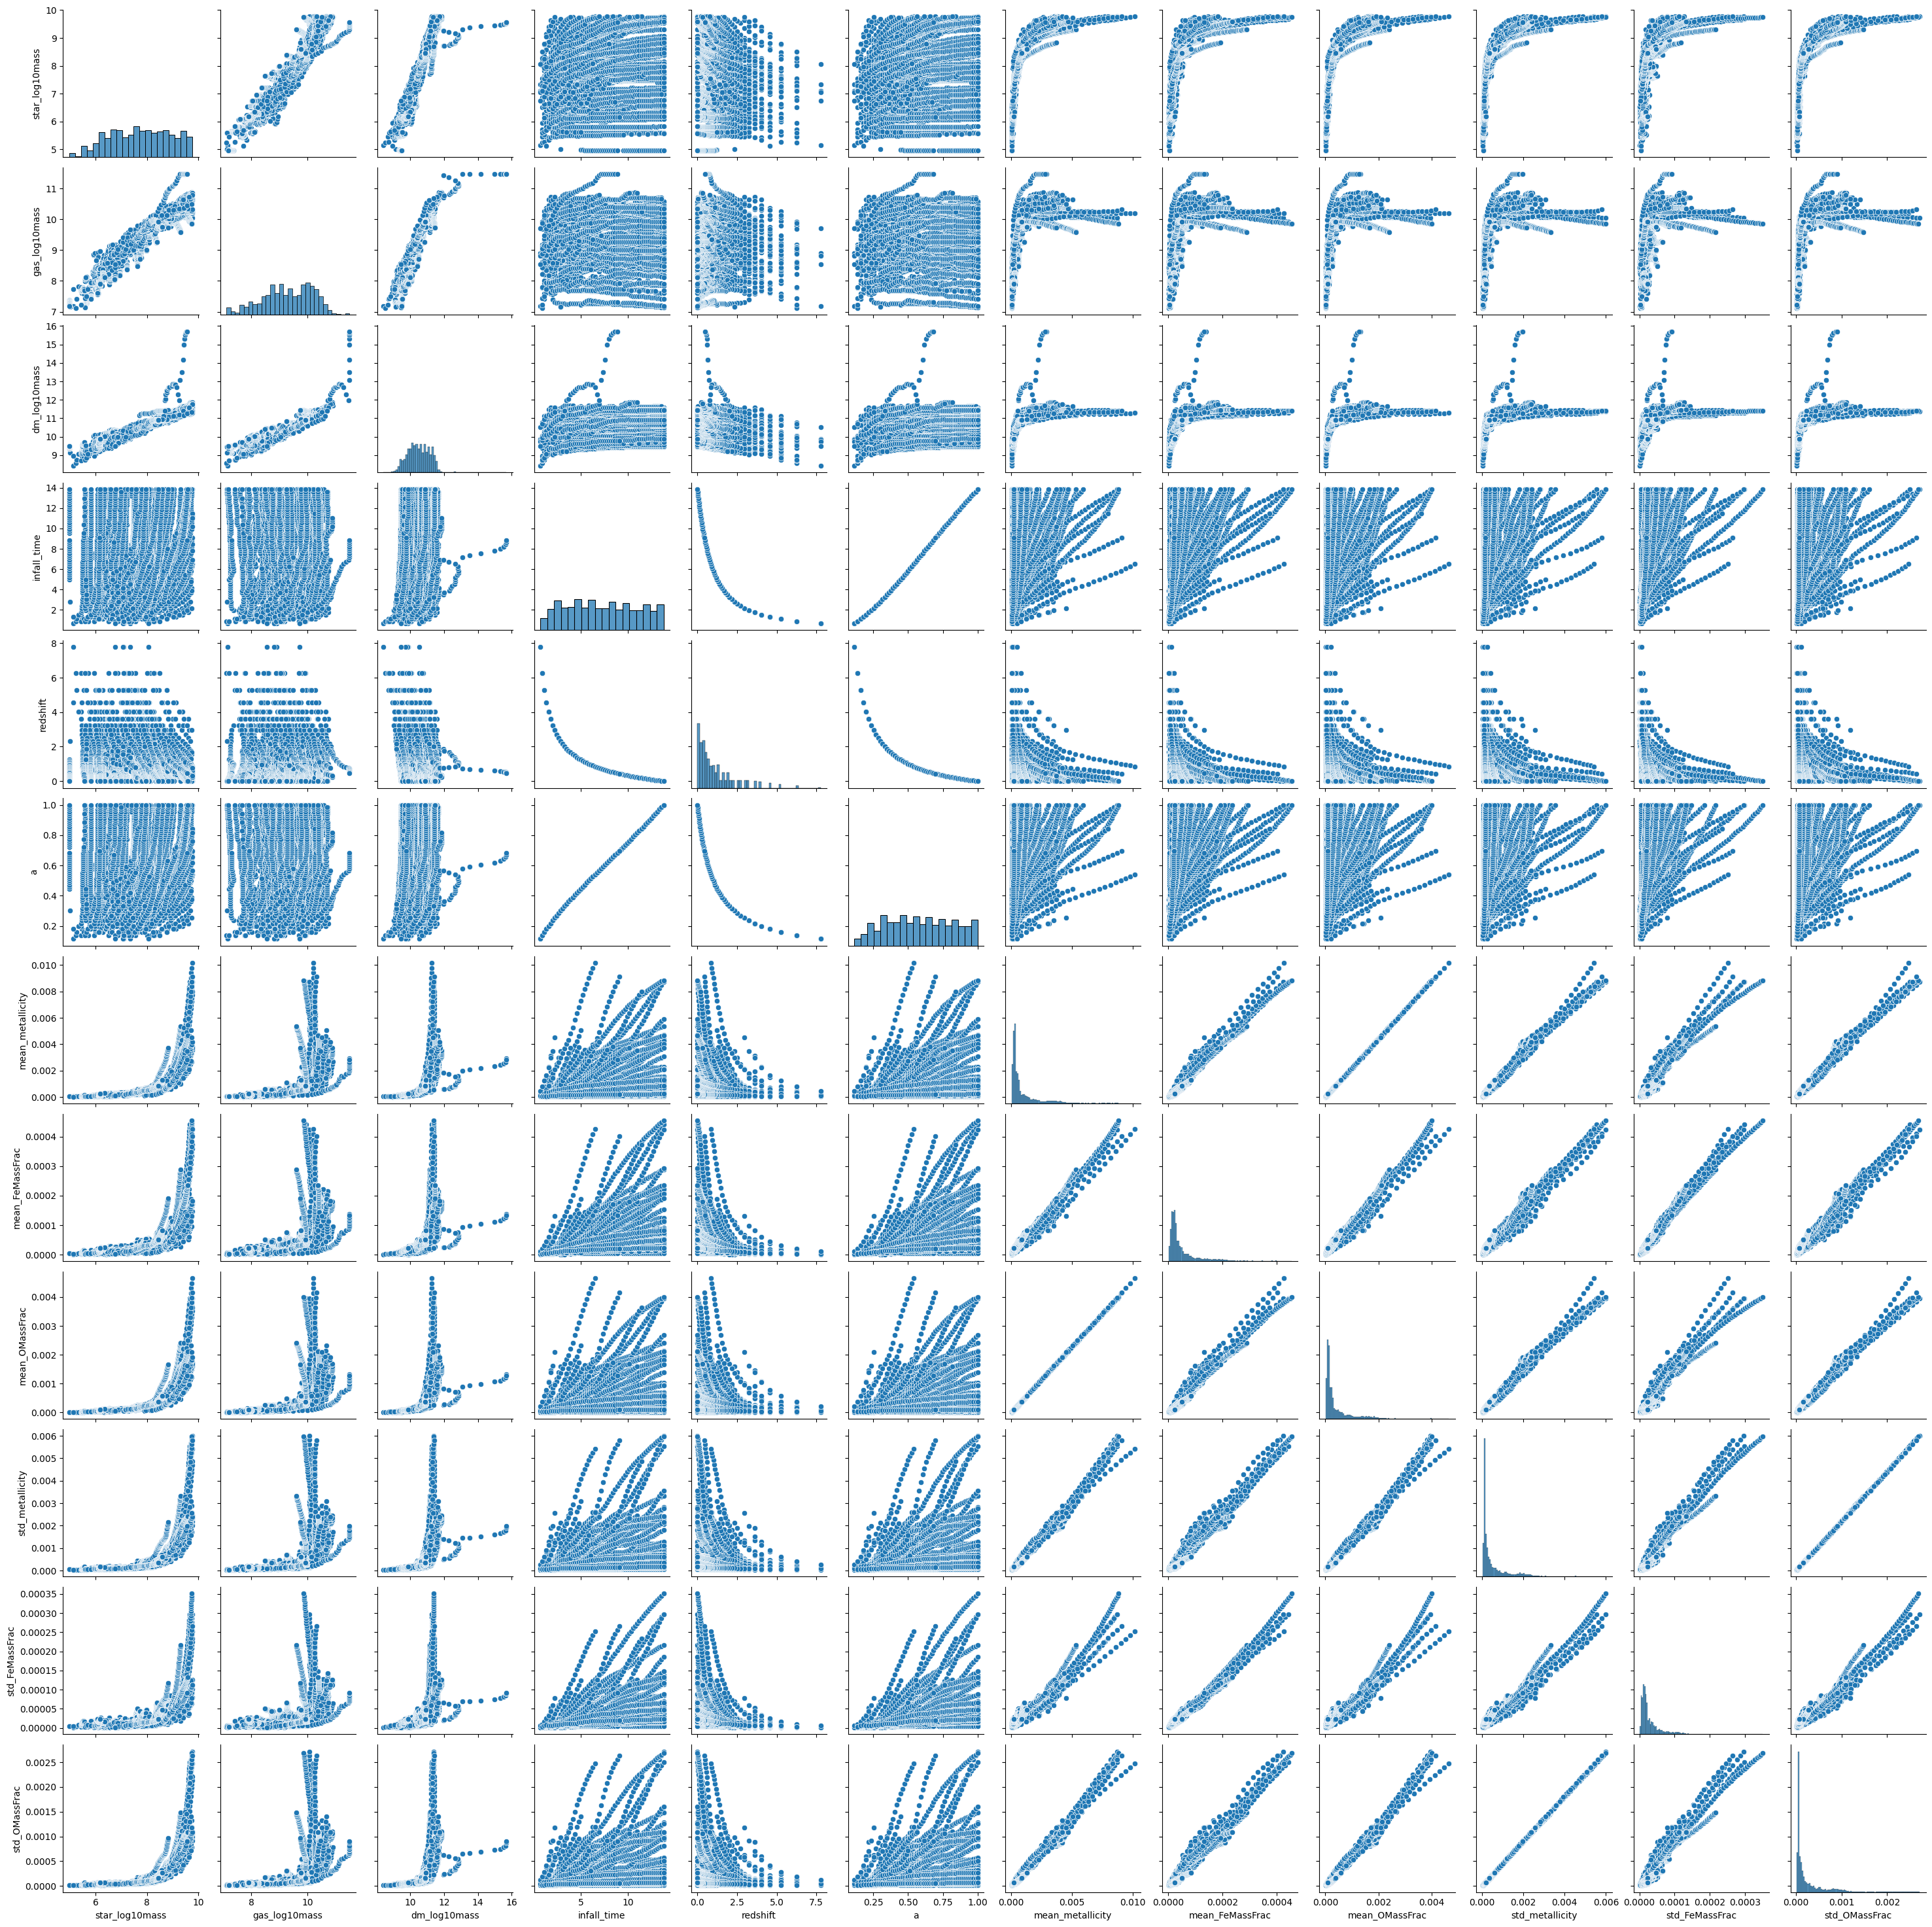

In [14]:
sns.pairplot(condtions_rescale)

[7.5101262]


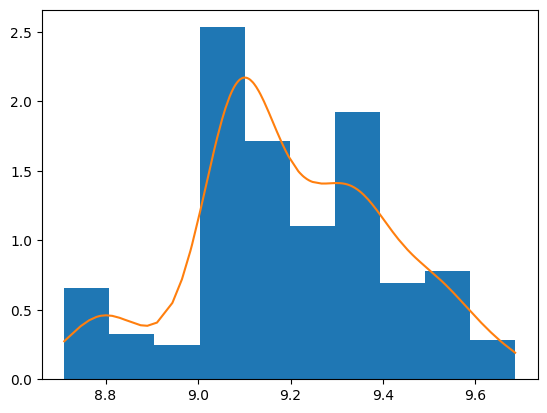

In [19]:
star_mass = conditions_rescale['star_log10mass'].sample(1).values
print(star_mass)

gas_mass = sorted(conditions_rescale[(star_mass[0] - star_mass[0]/100 < conditions_rescale['star_log10mass']) & (conditions_rescale['star_log10mass']<star_mass[0] + star_mass[0]/100)  ]['gas_log10mass'].values)
plt.hist(gas_mass, density=True)
kde = gaussian_kde(gas_mass)
kde_value = kde.evaluate(gas_mass)
plt.plot(gas_mass, kde_value)

In [62]:
def gen_conditions(conditions, percentage=10):
    kde = gaussian_kde(conditions['star_log10mass'])
    star_mass = kde.resample(1)[0][0]
    print(star_mass)
    cut_in_mass = conditions[(star_mass - star_mass*percentage/100 < conditions['star_log10mass']) & (conditions['star_log10mass']<star_mass + star_mass*percentage/100)]
    conditions_to_sample = cut_in_mass.columns.difference(['star_log10mass', 'infall_time', 'a', 'redshift'], sort=False)
    sample_conditions = np.zeros(len(conditions_to_sample))
    for i, col in enumerate(conditions_to_sample):
        possible_cond = cut_in_mass[col].values
        kde = gaussian_kde(possible_cond)
        sample_conditions[i] = kde.resample(1)[0][0]
    return sample_conditions 
        
sample_conditions = gen_conditions(conditions_rescale, percentage=1)
print(sample_conditions)

8.530310412040526
[1.00137187e+01 1.10163081e+01 9.33066483e-04 5.29234028e-05
 4.44642987e-04 5.18884501e-04 1.95866276e-05 2.12943841e-04]


In [ ]:
gen_conditions(conditions, 20)